In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
ds = xr.load_dataset("data/mini_lake.nc")

In [17]:
# ds.time.values

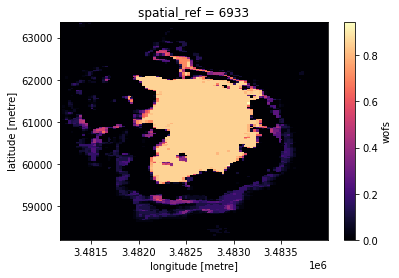

In [18]:
ds.wofs.mean(dim = "time").plot(cmap = "magma")

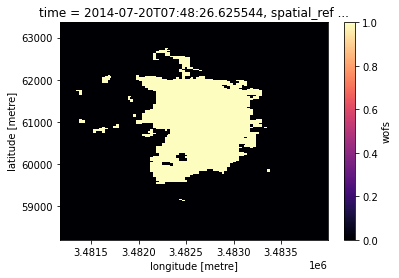

In [19]:
ds.wofs.isel(time = 16).plot(cmap = "magma")

In [20]:
ds.dims

Frozen(SortedKeysDict({'time': 35, 'latitude': 172, 'longitude': 94}))

In [21]:
data_array = ds.wofs.values

In [22]:
data_array.shape

(35, 172, 94)

In [23]:
z,x,y = data_array.shape

In [24]:
z,y,x = data_array.shape
empty_arr = np.empty((z,y,x,3))
empty_arr[:] = np.nan

In [25]:
on_color = [120,30,30]
off_color = [0,0,0]
empty_arr[data_array == 0] = off_color
empty_arr[data_array == 1] = on_color

In [26]:
out = data_array.astype(int).tolist()

In [27]:
with open("temp_arr.txt", "w") as fs:
    fs.write(str(out))

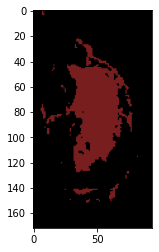

In [28]:
plt.imshow(empty_arr[0].astype(int))

In [29]:
import matplotlib.pyplot as plt

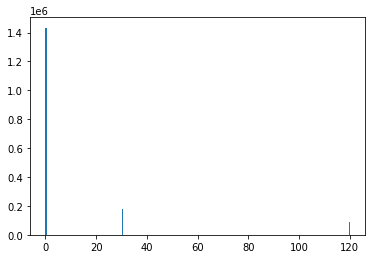

In [33]:
_ = plt.hist(empty_arr.reshape((x*y*z*3)), bins = 256)

In [39]:
# from itertools import product
# df = pd.DataFrame()
# for date, coords in product(ds.time.values,(product(ds.latitude.values, ds.longitude.values))):
#     print(date)
#     value = ds.sel(time = date, latitude = coords[0], longitude = coords[1]).wofs.values
#     if value == 1:
#         _df = pd.DataFrame([[date, coords[0], coords[1]]], columns=['date', 'latitude', 'longitude'])
#         df = df.append(_df)
# print('done')
# df.to_csv("data/coords.csv")

In [40]:
df = pd.read_csv("data/coords.csv")
df

,Unnamed: 0,date,latitude,longitude
0,0,2014-02-10 07:49:28.833114,63345.0,3481185.0
1,0,2014-02-10 07:49:28.833114,63345.0,3481395.0
2,0,2014-02-10 07:49:28.833114,63345.0,3481395.0
3,0,2014-02-10 07:49:28.833114,63345.0,3481425.0
4,0,2014-02-10 07:49:28.833114,63345.0,3481455.0
...,...,...,...,...
88121,0,2014-12-11 07:49:02.755100,59145.0,3482115.0
88122,0,2014-12-11 07:49:02.755100,59145.0,3482175.0
88123,0,2014-12-11 07:49:02.755100,59145.0,3482205.0
88124,0,2014-12-11 07:49:02.755100,58905.0,3482595.0


In [41]:
total_dims = len(ds.time.values) * len(ds.latitude.values) * len(ds.longitude.values)
total_dims

565880

In [42]:
len(df)/total_dims

0.1557326641690818

In [43]:
data = {}
for i,x in enumerate(sorted(np.unique(df.date.values))):
    data[x] = i

In [44]:
date_indices = [*map(lambda x: data[x], df.date.values )]

In [45]:
# sorted(np.unique(df.date.values))

In [46]:
dates = np.array([*map(np.datetime64, df.date.values)])
dates

array(['2014-02-10T07:49:28.833114000', '2014-02-10T07:49:28.833114000',
       '2014-02-10T07:49:28.833114000', ...,
       '2014-12-11T07:49:02.755100000', '2014-12-11T07:49:02.755100000',
       '2014-12-11T07:49:02.755100000'], dtype='datetime64[ns]')

In [47]:
dates = dates - dates.min()

In [48]:
from itertools import islice
 
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [49]:
min_jump = min(map(lambda x: abs(x[0] - x[1]), window(np.unique(dates).astype(int),n=2)))
min_jump

23912217000

In [50]:
import matplotlib.pyplot as plt

(array([5870.,    0.,    0.,    0.,    0., 5734.,    0.,    0.,    0.,
           0., 2934.,    0.,    0.,    0.,    0., 5784.,    0.,    0.,
           0.,    0.,    0., 2850.,    0.,    0.,    0.,    0., 2909.,
           0.,    0.,    0.,    0.,   59.,    0.,    0.,    0.,    0.,
        2838.,    0.,    0.,    0.,    0.,    0., 5498.,    0.,    0.,
           0.,    0., 2688.,    0.,    0.,    0.,    0., 5300.,    0.,
           0.,    0.,    0., 5203.,    0.,    0.,    0.,    0.,    0.,
        5506.,    0.,    0.,    0.,    0., 7182.,    0.,    0.,    0.,
           0., 7686.,    0.,    0.,    0.,    0., 3186.,    0.,    0.,
           0.,    0.,    0., 3186.,    0.,    0.,    0.,    0., 2783.,
           0.,    0.,    0.,    0., 5515.,    0.,    0.,    0.,    0.,
        5415.]),
 array([0.00000000e+00, 2.62655739e+14, 5.25311478e+14, 7.87967218e+14,
        1.05062296e+15, 1.31327870e+15, 1.57593444e+15, 1.83859017e+15,
        2.10124591e+15, 2.36390165e+15, 2.62655739e+15, 2.

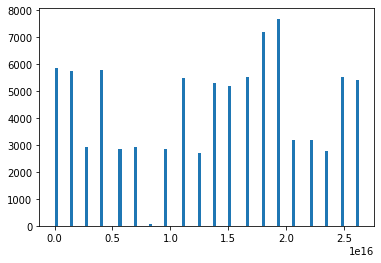

In [51]:
plt.hist(list(dates.astype(np.int)), bins = 100)

In [52]:
dates.astype(np.int)/min_jump

array([      0.        ,       0.        ,       0.        , ...,
       1098416.50910018, 1098416.50910018, 1098416.50910018])

(array([5870.,    0.,    0.,    0.,    0., 5734.,    0.,    0.,    0.,
           0., 2934.,    0.,    0.,    0.,    0., 5784.,    0.,    0.,
           0.,    0.,    0., 2850.,    0.,    0.,    0.,    0., 2909.,
           0.,    0.,    0.,    0.,   59.,    0.,    0.,    0.,    0.,
        2838.,    0.,    0.,    0.,    0.,    0., 5498.,    0.,    0.,
           0.,    0., 2688.,    0.,    0.,    0.,    0., 5300.,    0.,
           0.,    0.,    0., 5203.,    0.,    0.,    0.,    0.,    0.,
        5506.,    0.,    0.,    0.,    0., 7182.,    0.,    0.,    0.,
           0., 7686.,    0.,    0.,    0.,    0., 3186.,    0.,    0.,
           0.,    0.,    0., 3186.,    0.,    0.,    0.,    0., 2783.,
           0.,    0.,    0.,    0., 5515.,    0.,    0.,    0.,    0.,
        5415.]),
 array([      0.        ,   10984.165091  ,   21968.330182  ,
          32952.49527301,   43936.66036401,   54920.82545501,
          65904.99054601,   76889.15563701,   87873.32072801,
          98857.

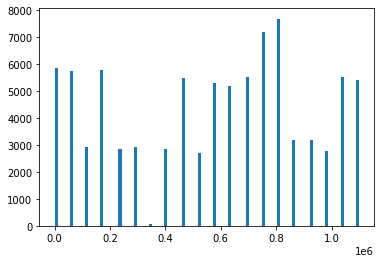

In [53]:
plt.hist(list(dates.astype(np.int)/min_jump), bins = 100)

In [54]:
# from sklearn.preprocessing import normalize
normalize = lambda x: np.linalg.norm(x)

normalize(dates.astype(int))

4.718351581571183e+18

In [ ]:
# from weakref import WeakValueDictionary

# class Singleton(type):
#     _instances = WeakValueDictionary()
#     def __call__(cls, *args, **kwargs):
#         if cls not in cls._instances:
#             # This variable declaration is required to force a
#             # strong reference on the instance.
#             instance = super(Singleton, cls).__call__(*args, **kwargs)
#             cls._instances[cls] = instance
#         return cls._instances[cls]

In [151]:
import os

from jinja2 import Template
from IPython.display import IFrame

import psutil

VOXEL_VIS_WEB_SVR_CMD = 'python3 server.py &'

class VoxelVisualizer():
    def _launch_server_if_not_running(self):
        # Determine if the server is running.
        process_cmds = (p.cmdline() for p in psutil.process_iter())
        cmd_found = False
        for cmd in process_cmds:
            for token in VOXEL_VIS_WEB_SVR_CMD.split():
                if token != '&' and token not in cmd:
                    break
                cmd_found = True
                break
            if cmd_found:
                break
        # If the server is not running, start it.
        if not cmd_found:
            os.system(VOXEL_VIS_WEB_SVR_CMD)
    
    def __init__(self):
        # Launch the webserver.    
        self._launch_server_if_not_running()
        fs = open('template.html','r')
        self.template = Template(fs.read())
        fs.close()
    
    def draw(self): #,arr: np.array):
#         if not np.array_equal(arr, arr.astype(bool)):
#             raise Exception("You need to pass a boolean array to use this")
        filled_template = self.template.render() #data = str_rep)
        self.save(filled_template, 'out1.html')
        vox_vis_server_port = os.environ['VOXEL_VISUALIZER_PORT']
        import requests
        url_if_server_is_client = f'http://localhost:{vox_vis_server_port}/static/out1.html'
        server_is_client = requests.get(url_if_server_is_client).text != 'Not Found'
        if server_is_client:
            url = url_if_server_is_client
        else:
            public_host_ip = requests.get('https://api.ipify.org').text
            url = f'http://{public_host_ip}:{vox_vis_server_port}/static/out1.html'
        self.iframe = IFrame(url, width=700, height=350)
        return self.iframe

    def save(self, data, location):
        fs = open(location, "w")
        fs.write(data)
        fs.close()
        return 

In [152]:
del voxel_visualizer

In [153]:
voxel_visualizer = VoxelVisualizer()

In [154]:
voxel_visualizer.draw()

In [70]:
# from IPython.display import Javascript, display, HTML

# # // import jQuery from "jquery";

# # // $.getJSON('https://ipinfo.io/json', function(data) {
# # //   console.log(JSON.stringify(data, null, 2));

# display(HTML("""  
# <script>
# function getIP(json) {
#   console.log("My public IP address is: " + json.ip);
# }
# </script>
# <script src="https://api.ipify.org?format=jsonp&callback=getIP"></script>

# // as seperate script tag
# <script type="application/javascript" src="https://api.ipify.org?format=jsonp&callback=getIP"> </script>

# });"""))

In [71]:
# display(Javascript("""  

# var xmlHttp = new XMLHttpRequest();
# // false for synchronous request
# // xmlHttp.open('GET', 'https://api.ipify.org', false);
# // xmlHttp.open('GET', 'https://google.org', false);
# // xmlHttp.open('GET', 'http://localhost:8100/static/out1.html', false);
# xmlHttp.open('GET', 'http://localhost:8100/get-client-ip', false);
# xmlHttp.send( null );
# console.log(xmlHttp.responseText);
# """))

In [42]:
# process_cmds = (p.cmdline() for p in psutil.process_iter())
# cmd_found = False
# for cmd in process_cmds:
# #     print(cmd)
#     for token in VOXEL_VIS_WEB_SVR_CMD.split():
#         if token != '&' and token not in cmd:
#             print(token, cmd)
#             break
#         cmd_found = True
#         break
#     if cmd_found:
#         break

In [25]:
# import inspect
# inspect.signature(IFrame, allow)

In [150]:
# from IPython.display import display, HTML
# from jinja2 import Environment, FileSystemLoader

# jinja_env = Environment(loader=FileSystemLoader('.'))

# # fs = open("template.html","r")
# # HTML_str = Template(fs.read()).render()
# HTML_str = env.get_template('template.html').render()
# HTML_str = HTML_str.replace('\n', '').replace('\t', '')
# HTML_str
# # display(HTML('<h1>hi</h1>'))
# # display(HTML(HTML_str))